In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DATA EXTRACTION SETUP
# NOTE: If you are running this locally, ensure your 'Images' folder is in the 
# current directory and skip this cell. 
# If on Google Colab, update the path below to point to your uploaded zip files.
!mkdir -p /content/train_images
!mkdir -p /content/test_images

!unzip -q "/content/drive/MyDrive/CDC_Project/Data/Images/Train.zip" -d /content/train_images
!unzip -q "/content/drive/MyDrive/CDC_Project/Data/Images/Test.zip" -d /content/test_images

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Update this base
BASE_PATH = "/content/drive/MyDrive/CDC_Project/Data"

TRAIN_CSV = f"{BASE_PATH}/train.csv"
TEST_CSV  = f"{BASE_PATH}/test.csv"

TRAIN_IMAGE_DIR = "/content/train_images/Train"
TEST_IMAGE_DIR  = "/content/test_images/Test"

In [5]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

KEY_FEATURES = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "grade",
    "sqft_living15",
    "view",
    "waterfront",
    "lat",
    "long"
]

train_df = train_df[["id", "price"] + KEY_FEATURES]

# Target (log transform)
y = np.log1p(train_df["price"].values)

# Tabular features
X_tab = train_df[KEY_FEATURES].values

scaler = StandardScaler()
X_tab = scaler.fit_transform(X_tab)

In [6]:
(train_ids, val_ids, X_tab_train, X_tab_val, y_train, y_val) = train_test_split(
    train_df["id"].values,
    X_tab,
    y,
    test_size=0.2,
    random_state=42
)

In [7]:
def load_and_preprocess(img_id, tabular, label):
    img_path = tf.strings.join(
        [TRAIN_IMAGE_DIR, "/", tf.strings.as_string(img_id), ".png"]
    )

    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)

    return {"image_input": img, "tabular_input": tabular}, label

In [8]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_ids, X_tab_train, y_train)
)
train_ds = (
    train_ds
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_ids, X_tab_val, y_val)
)
val_ds = (
    val_ds
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
image_input = layers.Input(shape=(224, 224, 3), name="image_input")

base_cnn = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=image_input
)
base_cnn.trainable = False

x = layers.GlobalAveragePooling2D()(base_cnn.output)
x = layers.Dense(256, activation="relu")(x)

tabular_input = layers.Input(shape=(9,), name="tabular_input")
t = layers.Dense(64, activation="relu")(tabular_input)
t = layers.Dense(32, activation="relu")(t)

combined = layers.Concatenate()([x, t])

z = layers.Dense(128, activation="relu")(combined)
z = layers.Dense(64, activation="relu")(z)

output = layers.Dense(1, activation="linear")(z)

model = models.Model(
    inputs=[image_input, tabular_input],
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mse",
    metrics=["mae"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,160,289 (92.16 MB)

 Trainable params: 572,577 (2.18 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - loss: 29.7755 - mae: 3.5067 - val_loss: 0.5319 - val_mae: 0.5776
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 57s 123ms/step - loss: 0.4580 - mae: 0.5339 - val_loss: 0.3219 - val_mae: 0.4445
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 53s 125ms/step - loss: 0.2904 - mae: 0.4268 - val_loss: 0.2568 - val_mae: 0.3977
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 53s 124ms/step - loss: 0.2341 - mae: 0.3811 - val_loss: 0.2209 - val_mae: 0.3700
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 52s 122ms/step - loss: 0.2032 - mae: 0.3551 - val_loss: 0.2213 - val_mae: 0.3730
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - loss: 0.1777 - mae: 0.3320 - val_loss: 0.1856 - val_mae: 0.3391
Epoch 7/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 82s 122ms/step - loss: 0.1579 - mae: 0.3139 - val_loss: 0.1779 - val_mae: 0.3323
Epoch 8/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 51s 119ms/step - loss: 0.1525 - mae: 0.3090 - val_loss: 0.1655 - val_mae: 0.3200
Epoch 9/20
406/406 ━━━━━━━━━━━━

In [13]:
val_preds = model.predict(val_ds).ravel()

rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2 = r2_score(y_val, val_preds)

print("Validation RMSE:", rmse)
print("Validation R²:", r2)

102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 138ms/step
Validation RMSE: 0.4024052433616109
Validation R²: 0.4131987174550745


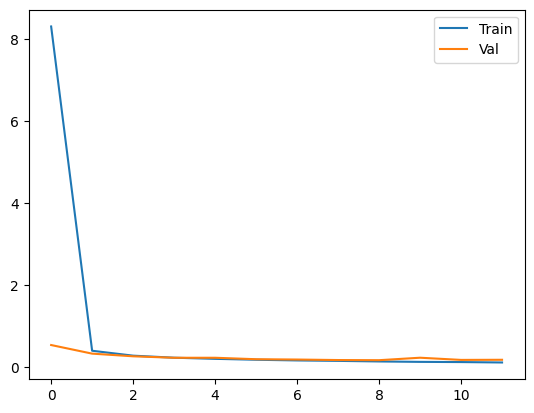

In [14]:
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend()
plt.show()

In [15]:
full_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["id"].values, X_tab, y)
)

full_ds = (
    full_ds
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

model.fit(full_ds, epochs=10)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - loss: 0.1346 - mae: 0.2890
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - loss: 0.1253 - mae: 0.2789
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - loss: 0.1151 - mae: 0.2676
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step - loss: 0.1061 - mae: 0.2574
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - loss: 0.0993 - mae: 0.2493
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - loss: 0.0942 - mae: 0.2430
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - loss: 0.0975 - mae: 0.2475
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - loss: 0.0974 - mae: 0.2473
Epoch 9/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - loss: 0.0847 - mae: 0.2305
Epoch 10/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - loss: 0.0775 - mae: 0.2195


In [16]:
def load_test(img_id, tabular):
    img_path = tf.strings.join(
        [TEST_IMAGE_DIR, "/", tf.strings.as_string(img_id), ".png"]
    )

    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = preprocess_input(img)

    return {"image_input": img, "tabular_input": tabular}

In [17]:
X_test_tab = scaler.transform(test_df[KEY_FEATURES].values)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["id"].values, X_test_tab)
)

test_ds = (
    test_ds
    .map(load_test, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [18]:
test_preds_log = model.predict(test_ds).ravel()
test_preds = np.expm1(test_preds_log)

169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 246ms/step


## Grad Cam

In [19]:
for layer in model.layers:
    print(layer.name)

image_input
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

In [20]:
def grad_cam(model, image, tabular, last_conv_layer_name):

    # Created a model that maps inputs → last conv layer + output
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(
            {"image_input": image, "tabular_input": tabular},
            training=False
        )
        loss = predictions[:, 0]

    # Computing gradients
    grads = tape.gradient(loss, conv_outputs)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [21]:
# Take one batch
for batch in train_ds.take(1):
    inputs, labels = batch
    image_batch = inputs["image_input"]
    tabular_batch = inputs["tabular_input"]

# Select ONE sample
img_sample = image_batch[0:1]
tab_sample = tabular_batch[0:1]

heatmap = grad_cam(
    model,
    img_sample,
    tab_sample,
    last_conv_layer_name="conv5_block3_out"
)

In [22]:
def overlay_gradcam(original_img, heatmap, alpha=0.4):
    # Resize heatmap
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)

    # Apply color map
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
    return overlay

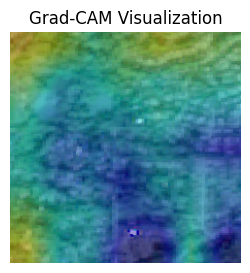

In [23]:
# Convert preprocessed image back to displayable format
img_display = img_sample[0].numpy()
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
img_display = np.uint8(255 * img_display)

overlay = overlay_gradcam(img_display, heatmap)

plt.figure(figsize=(3, 3))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

In [24]:
def grad_cam(model, img_tensor, tab_tensor, last_conv_layer_name):

    img_tensor = tf.cast(img_tensor, tf.float32)
    tab_tensor = tf.cast(tab_tensor, tf.float32)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(
            [img_tensor, tab_tensor],
            training=False
        )
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [25]:
def overlay_gradcam(original_img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [26]:
NUM_IMAGES = 40

images_collected = []
tabular_collected = []
prices_collected = []

# ONLY 2 batches
for batch in train_ds.take(2):
    inputs, labels = batch
    images_collected.append(inputs["image_input"])
    tabular_collected.append(inputs["tabular_input"])
    prices_collected.append(labels)

# Concatenate and slice
images_collected = tf.concat(images_collected, axis=0)[:NUM_IMAGES]
tabular_collected = tf.concat(tabular_collected, axis=0)[:NUM_IMAGES]
prices_collected = tf.concat(prices_collected, axis=0)[:NUM_IMAGES]

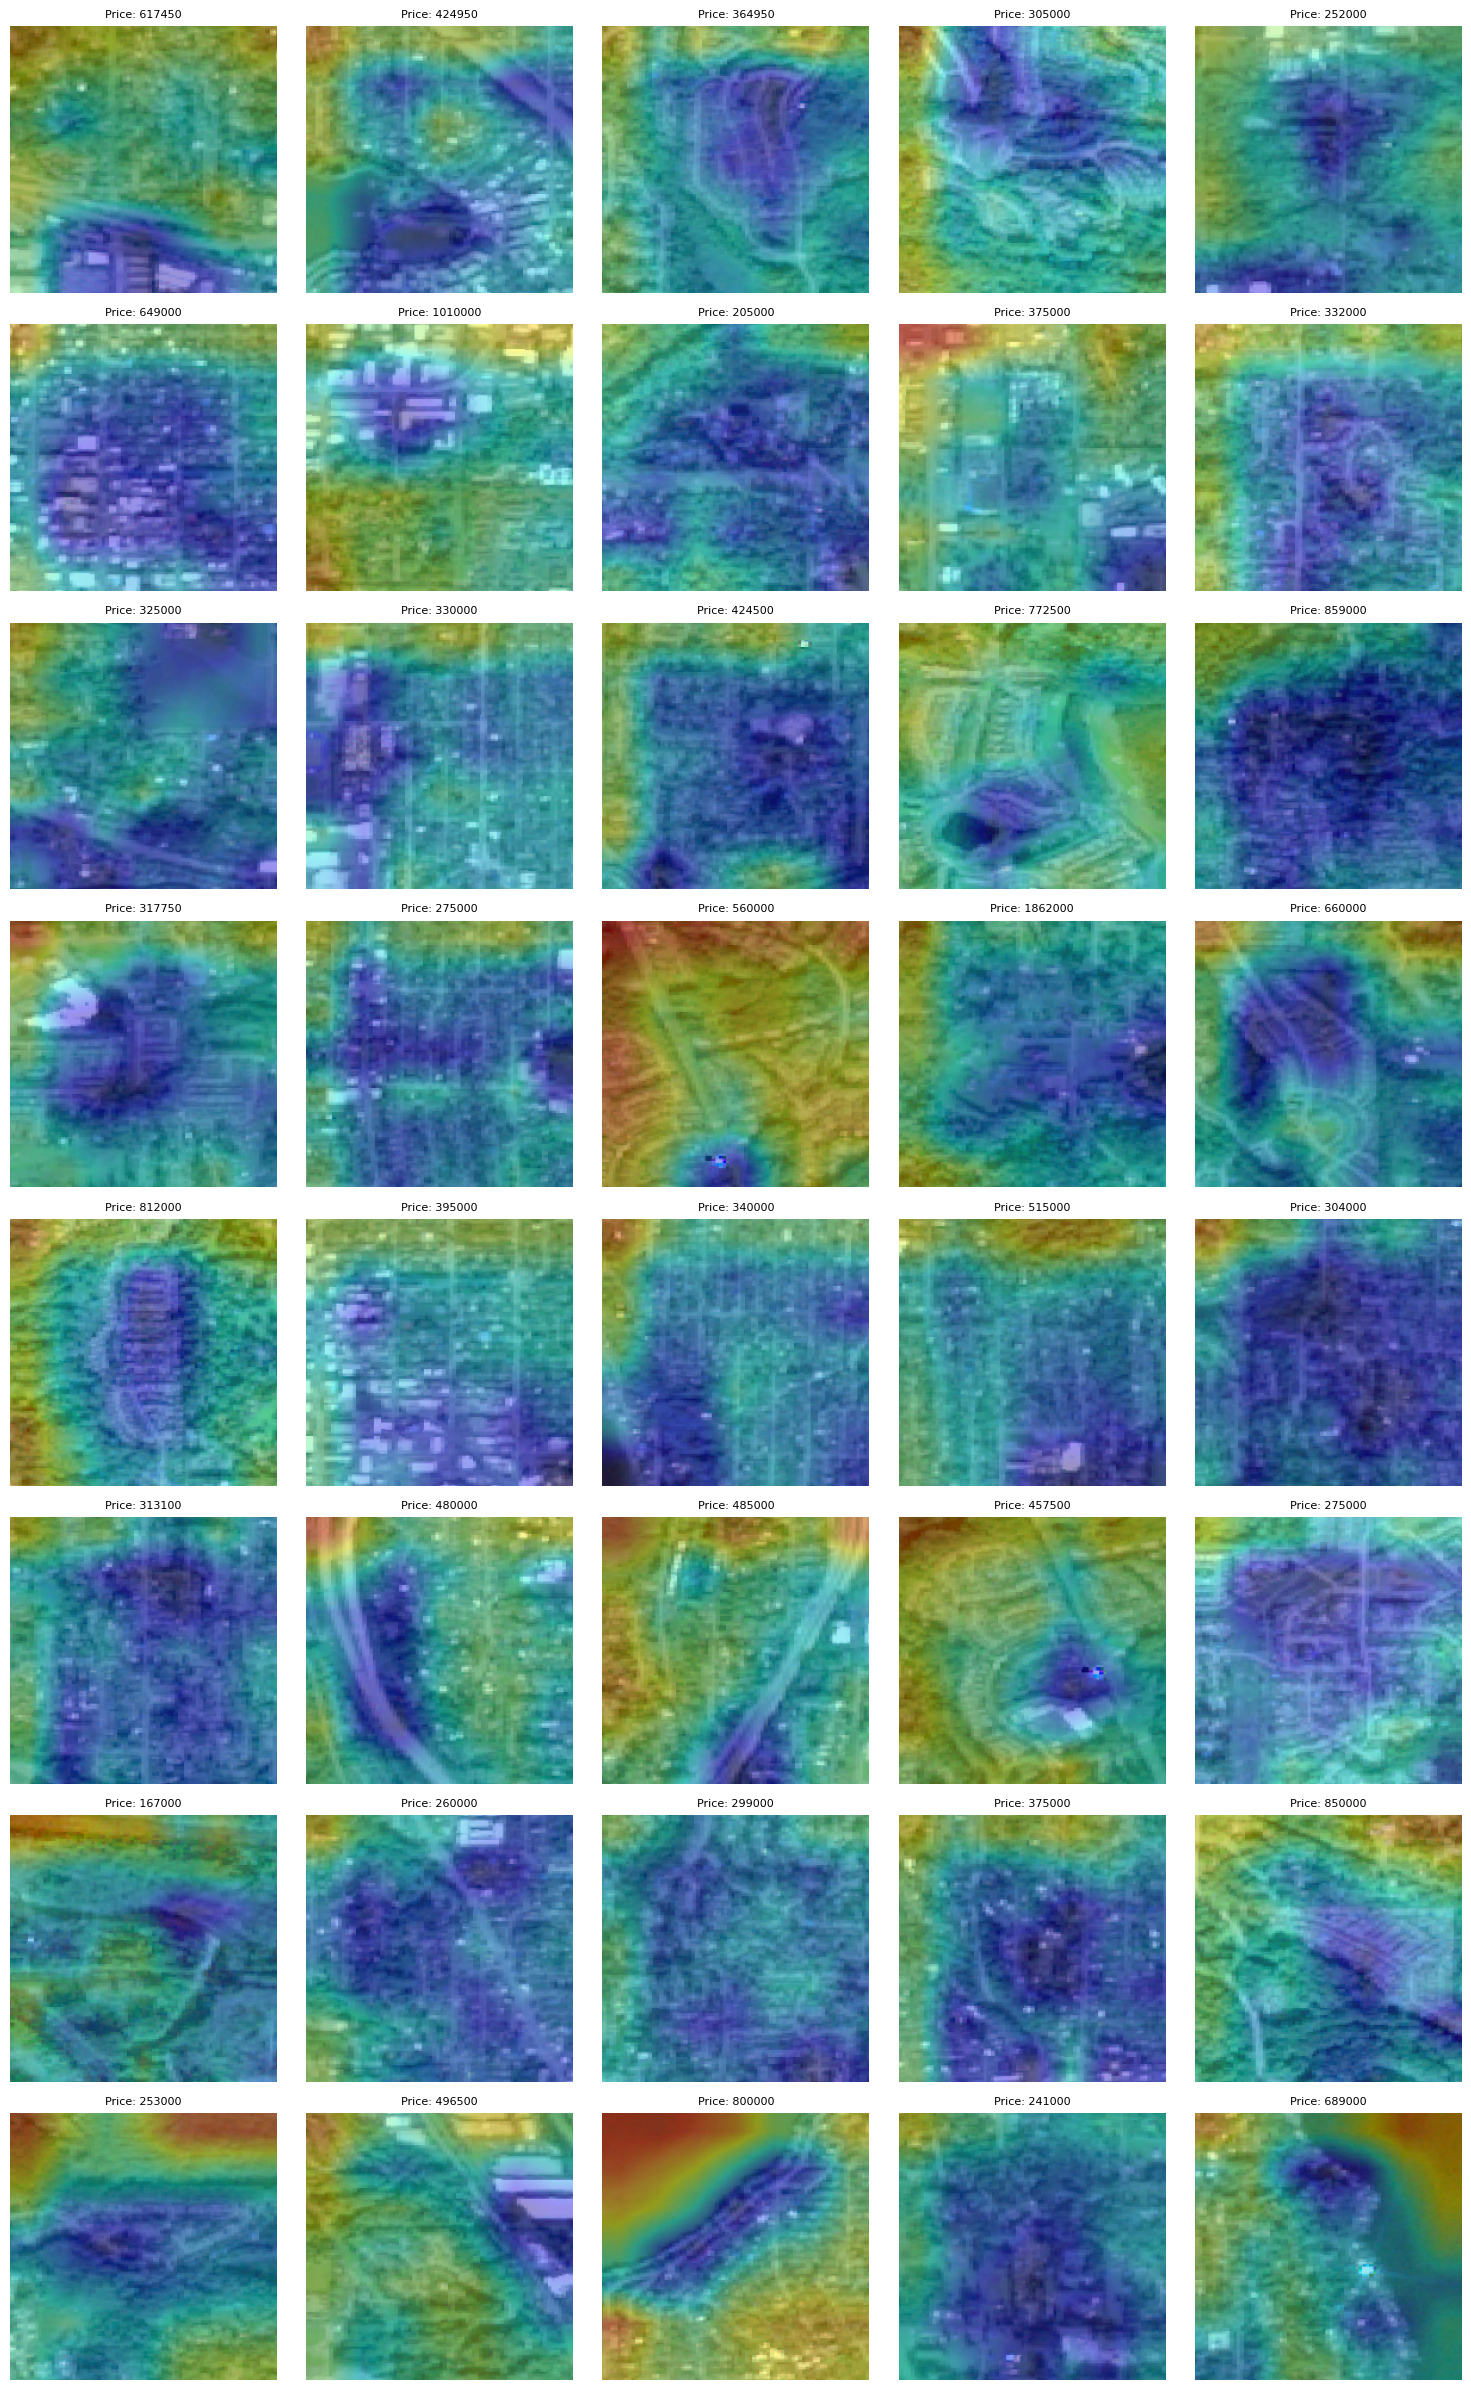

In [29]:
ROWS = 8
COLS = 5

fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 24))
axes = axes.flatten()

for i in range(NUM_IMAGES):
    img_sample = images_collected[i:i+1]
    tab_sample = tabular_collected[i:i+1]
    price = prices_collected[i].numpy()

    heatmap = grad_cam(
        model,
        img_sample,
        tab_sample,
        last_conv_layer_name="conv5_block3_out"
    )

    # De-normalize image for display
    img_display = img_sample[0].numpy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    img_display = np.uint8(255 * img_display)

    overlay = overlay_gradcam(img_display, heatmap)

    axes[i].imshow(overlay)
    axes[i].set_title(f"Price: {np.expm1(price):.0f}", fontsize=8)
    axes[i].axis("off")

plt.tight_layout()
plt.show()